# Sistema de Recomendação de Produtos para Empresas e E-Commerce

# Introdução

Com base em comportamentos anteriores, um sistema de recomendação prevê a possibilidade de um usuário/cliente preferir um item. O propósito dos sistemas de recomendação é recomendar coisas novas que não foram vistas antes pelas pessoas. 

Um sistema de recomendação bem desenvolvido ajudará as empresas a melhorar a experiência do cliente no site e resultará em uma melhor aquisição e retenção de clientes. 


## Dataset 

 Para o projeto usamos um conjunto de dados público de comércio eletrônico brasileiro de pedidos feitos na <a href="https://olist.com/"> Olist Store </a>. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 realizados em diversos mercados no Brasil.

 Link do dataset: <a href="https://www.kaggle.com/olistbr/brazilian-ecommerce" target="_black" >Kaggle - Brazilian E-Commerce Public Dataset by Olist</a> 


## Objetivos:

Desenvolver um sistema de recomendação baseado na jornada de um novo cliente desde o momento em que ele chega ao site da empresa pela primeira vez até quando ele faz compras repetidas. O sistema de recomendação é projetado em 3 partes com base no contexto de negócios: 

* Parte 1: Sistema baseado em produtos mais populares, voltado para novos clientes.

* Parte 2: Modelo de sistema de filtragem colaborativa baseado no histórico de compras do cliente e avaliações fornecidas por outros usuários que compraram itens semelhantes.

* Parte 3: Modelo usando análise sentimento dos comentários deixados por outros clientes para recomendar produtos semelhantes e os melhores vendedores.

## Importando as Bibliotecas e os Dados

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
import spacy.cli
import pt_core_news_sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [76]:
customers = pd.read_csv('olist_customers_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

## Parte 1

Basear-se na popularidade é uma ótima estratégia para atingir novos clientes com os produtos mais populares vendidos no site de uma empresa e é muito útil para iniciar um mecanismo de recomendação do zero. 

In [77]:
# uni dois dataframes
product_order = pd.merge(order_items,products)
product_order.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


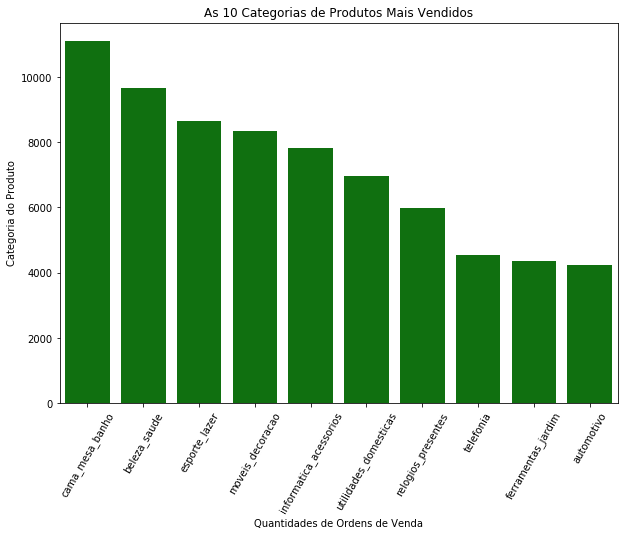

In [78]:
# seleciona as 10 categorias de produtos mais populares
top_products = product_order['product_category_name'].value_counts()\
                .reset_index().nlargest(10,'product_category_name')

# gráfico de barras com as 10 categorias populares
plt.figure(figsize = (10,7))
sns.barplot(data = top_products, y = 'product_category_name', x = 'index', color = 'green')
plt.title('As 10 Categorias de Produtos Mais Vendidos')
plt.xlabel('Quantidades de Ordens de Venda')
plt.xticks(rotation=60)
plt.ylabel('Categoria do Produto');

In [79]:
# uni dataframes
product_order_rating = pd.merge(product_order,order_reviews)

# agrupa e ordena os produtos pelas avaliações  
popular_products = pd.DataFrame(product_order_rating.groupby('product_id')['review_score'].count())
most_popular = popular_products.sort_values('review_score', ascending=False)
most_popular.head(10)

,review_score
product_id,
aca2eb7d00ea1a7b8ebd4e68314663af,527
99a4788cb24856965c36a24e339b6058,491
422879e10f46682990de24d770e7f83d,487
389d119b48cf3043d311335e499d9c6b,392
368c6c730842d78016ad823897a372db,391
53759a2ecddad2bb87a079a1f1519f73,375
d1c427060a0f73f6b889a5c7c61f2ac4,343
53b36df67ebb7c41585e8d54d6772e08,323
154e7e31ebfa092203795c972e5804a6,293


<Figure size 1440x1368 with 0 Axes>

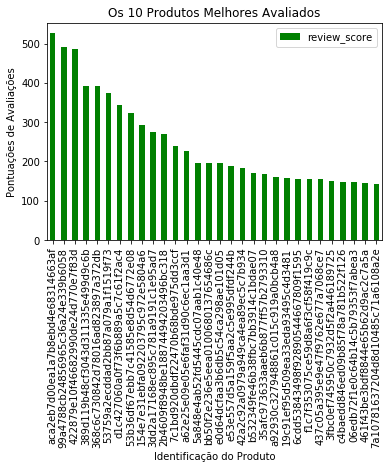

In [80]:
# gráfico de barras com os 10 produtos populares
plt.figure(figsize = (20,19))
most_popular.head(30).plot(kind = "bar", color='green')
plt.title("Os 10 Produtos Melhores Avaliados")
plt.xlabel("Identificação do Produto")
plt.ylabel("Pontuações de Avaliações")
plt.show()

* Os gráficos acima mostram as cetgorias e os produtos mais populares (organizados em ordem decrescente) vendidos pela empresa.

* Produtos e cama_mesa_banho são os mais populares

* O produto ID aca2eb7d00ea1a7b8ebd4e68314663af é o mais popular

## Parte 2

Em sistemas de filtragem coletiva, precisamos criar uma matriz de produtos x usuários. Cada linha é o produto e cada coluna é um usuário. Em seguida calculamos a similaridade  entre as linhas. Se a semelhança for alta o suficiente, podemos recomendar o produto.

In [81]:
# uni os dataframes
customers_order = pd.merge(product_order_rating,orders)

dataset = pd.merge(customers_order, customers)
dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,...,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,...,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG


In [82]:
# lista com colunas que não serão usadas
col_drop = ['shipping_limit_date', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_creation_date',
       'review_answer_timestamp',  'customer_zip_code_prefix','order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_city', 'customer_state' ]

In [83]:
# apaga as colunas na lista do dataset
dataset1 = dataset.drop(col_drop,axis=1)

In [84]:
# pega apenas as primeiras 10000linhas
dataset2 = dataset1.head(10000)
dataset2.shape

(10000, 11)

In [85]:
# cria uma matriz de pivotamento
reviews_matrix = dataset2.pivot_table(values='review_score', index='product_id', columns='customer_unique_id',fill_value=0)

reviews_matrix.head()

In [86]:
reviews_matrix.shape

customer_unique_id,00053a61a98854899e70ed204dd4bafe,0014a5a58da615f7b01a4f5e194bf5ea,001926cef41060fae572e2e7b30bd2a4,002feefec5af0a3b26ee7839c66d205e,0050dcff37f8b9ff611d245e30572b46,00575b2023dedcc0f3e81a938834689b,0062adafa3846d9f372d8f1bde591b24,0064a1b5f5cddd047c987b988a90c8c1,0076a71311bb2386a353f5ba87d2aa29,0078108af1d2dc4b1601c744ca581b4f,...,ff994a455350d9f24c79a7482b89dfe6,ff9c5dff16d7d6bfefc2acf5088d7b90,ffab5330bd7b40979ab6726b2e02292e,ffb2ae2aa0951d0885d7cd9a218b0c46,ffbcd1715dfbead64e1b896044d73c76,ffcf1dc25f2222aea1aef48841f20f3a,ffe6305176b9431a3eda3cf8904d7eb7,ffe9e41fbd14db4a7361347c56af5447,ffeb904468642a1ce663a322629801cb,ffec490ab531184a483efe2eedd68908
product_id,,,,,,,,,,,,,,,,,,,,,
001b72dfd63e9833e8c02742adf472e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00ffe57f0110d73fd84d162252b2c784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0105b5323d24fc655f73052694dbbb3a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
016711f78a6a87696645db0a6a834826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01c666c82f414c762ad21bffa56e8b49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(599, 8540)

### Decompondo a Matriz

Como temos muitas colunas em na matriz de pivotamento, podemos reduzir a quantiade de variáveis realizando uma redução da dimensionalidade, usando a ferramenta TruncatedSVD.

In [87]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(reviews_matrix)
decomposed_matrix.shape

(599, 10)

### Matriz de Correlação

Aqui calculamos o correlação entre os produtos.

In [88]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(599, 599)

Vamos assumindo que o cliente comprou o produto_id escolhido aleatoriamente e ver como o sistema recomendas produtos similares.

In [89]:
# escolhe aleatoriamente um produto
id = np.random.choice(dataset2['product_id'].values,1)
# cria uma lista com os índices a matriz dos produtos
product_names = list(reviews_matrix.index)
# associa os índices com os id dos produtos
product_ID = product_names.index(id)

In [104]:
print(f"Produto Escolhido: {id}")

Produto Escolhido: 29e690f79f608a27a9a02dbf5c3c0c93


In [90]:
# pega as correlações dos produtos
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(599,)

### Recomendando os 10 principais produtos altamente correlacionados em sequência 

In [91]:
Recommend_product = list(reviews_matrix.index[correlation_product_ID > 0.90])

# Remove o item já comprado pelo cliente 
Recommend_product.remove(id) 

# exibe os produtos similares
Recommend_product[0:10]

['0105b5323d24fc655f73052694dbbb3a',
 '028b3574d7619f191a7345161ae590e4',
 '0c753fe6a58dfa7a27bda5de76e779c3',
 '0cf41187284d7f099adc8415a743ebbd',
 '0f80705139ce16ea35bb489987399b55',
 '15c30c08ae39469fbf52befff9569adb',
 '1fe8e6e01596885617fa1c90d29c2f81',
 '21b1c2f67a9aafb5af0eb06c13b9dbda',
 '2770305847be150f16eb0b25fa7c171b',
 '29e690f79f608a27a9a02dbf5c3c0c93']

## Parte 3

Vamos treinar um modelo de análise de sentimentos com os comentários deixados pelos clientes usando a técnica de feature extraction TF-IDF. Aqui selecionamos os melhores produtos similares e os vendedores.


In [92]:
# cópia do dataset
dataset3 = dataset2.copy()

Para extrair somente as palavras importantes do texto, temos que retirar palavras que não transmitem informações, como pronomes e preposições. Para isso usamos a ferramento 'stopwords'. Palavras como 'não' e 'nem' podem ser importantes na análise de sentimentos, por isso vamos tirá-las da lista de stopwords.

In [93]:
stopwords_pt = stopwords.words("portuguese")

stopwords_pt.remove('não')
stopwords_pt.remove('nem')

spc_pt = pt_core_news_sm.load()

Como estamos interessados justamente no texto, vamos juntar as colunas review_comment_title e review_comment_message em uma só e tirar entradas que não possuem texto. Para isso criamos uma função chamada 'preprocessamento'

In [94]:
def preprocessamento(data):
    # remove os duplicados
    data.drop_duplicates("review_id", inplace = True)
    # preenche valores nulos
    data.fillna('', inplace = True)
    # concatenando as duas colunas
    data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message'] 
    # removendo entradas sem texto
    data = data[data['review'] != ' ']

    return data 

Vamos criar outra função que  deixa tudo em minusculo, filtra apenas letras,  retira stopwords, lemmatiza e retorna a string resultante.

In [95]:
def processamneto_texto(texto):
    # deixa em minúsculo
    texto = texto.lower()
    # retira números
    texto = re.sub(r"[\W\d_]+", " ", texto)
    # verifica se a palavra não está na lista de stopwords
    texto = [pal for pal in texto.split() if pal not in stopwords_pt]
    # lematiza (retira variações de palavras)
    spc_texto = spc_pt(" ".join(texto))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]
  
    return " ".join(tokens)

In [96]:
# aplica as funções no dataset
dataset3 = preprocessamento(dataset3)
dataset3.loc[:,'review'] = dataset3.loc[:,'review'].apply(processamneto_texto)

Há 5 valores de score diferentes (indo de 1 - pior até 5 - melhor), porém, para facilitar nossa tarefa, vamos classificar as reviews apenas como positiva ou negativa. Se o score for menor ou igual a 3, consideraremos negativa (0) e caso contrário, positiva (1).

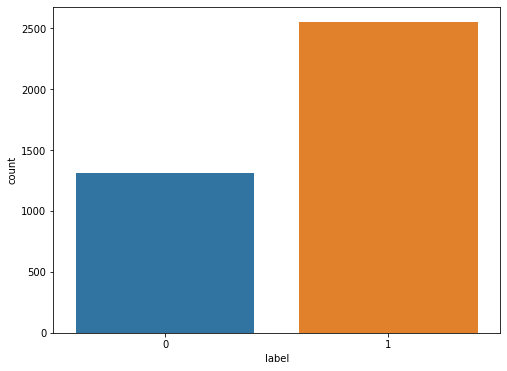

In [97]:
labels = []

for score in dataset3.loc[:,'review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

dataset3['label'] = labels

plt.figure(figsize=(8,6))
sns.countplot(dataset3['label'])
plt.show()

In [98]:
# remove reviews vazias
dataset3 = dataset3[dataset3['review'] != '']
texto = dataset3['review']

# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vetorizando
X_tfidf = tfidf_vect.fit_transform(texto)


In [99]:
# divide o dataset em conjunto de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, dataset3['label'],
                                                        test_size=0.3, random_state = 10)

Agora criamos uma função que recebe o y_test, o y_predito e mostra as principais metricas.


In [100]:
def mostra_metricas(y_true, y_pred):
      
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

Acurácia:  0.8842471714534378

AUROC: 0.8578582155418846

F1-Score: 0.8819200672309

Matriz de confusão:


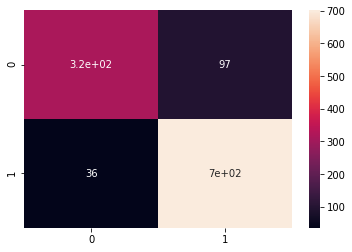

In [101]:
# Instanciando a reg. logistica
reglog = LogisticRegression()

# Aplicando o modelo
reglog.fit(X_train, y_train)

# Predicao
y_pred = reglog.predict(X_test)

# Analisa as métricas
mostra_metricas(y_test, y_pred)

O modelo de regressão logística (com TF-IDF), obteve  acurácia e F1 de 88% e AUROC de 86% (arredondando). 

Com o modelo treinado, criamos uma tabela com o id dos vendedores, produtos e classificações (positiva-1 ou negativa-0)

In [102]:
seller = pd.DataFrame()
seller['vendedor'] = dataset3['seller_id']
seller['produto_vendido'] = dataset3['product_id']
seller['recomendar'] = reglog.predict(X_tfidf)

seller.head()

,vendedor,produto_vendido,recomendar
0,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,1
1,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,1
2,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,1
6,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,1
9,48436dade18ac8b2bce089ec2a041202,4244733e06e7ecb4970a6e2683c13e61,0


Por fim, usando o id do produto escolhido e os produtos similares encontrados na parte 2, podemos selecionar os melhores produtos similares e vendedores para recomendar ao cliente.

In [111]:
# cria duas listas vazias para adicionar os dados
vendedor = []
produto = []

# usando os id dos produtos similares encontrados antes
for id in Recommend_product[0:10]:
    # se os produtos similares estiverem na tabela de melhor avaliação
    if id in seller.produto_vendido.values:
        # encontra o índice dos produtos na tabela
        idx = seller[seller.produto_vendido == id].index.values
        # se a avaliação for positiva
        if seller.loc[idx,'recomendar'].values.any() == 1:
            # adiciona o id produto na lista
            produto.append(id)
            # adiciona o id vendedor na lista
            vendedor.append(seller.loc[idx,'vendedor'].values)
    
# cria um dataframe com os produtos similares e vendedores com avaliação positiva
Recommend_seller = pd.DataFrame()
Recommend_seller['produto'] = produto
Recommend_seller['melhores_vendedores'] = vendedor

print(f"Produtos similares ao {id}:")
print(list(Recommend_seller['produto']))
print()
print("Vendedores Recomendados:")
print(Recommend_seller["melhores_vendedores"])

Produtos similares ao 29e690f79f608a27a9a02dbf5c3c0c93:
['0f80705139ce16ea35bb489987399b55', '15c30c08ae39469fbf52befff9569adb', '21b1c2f67a9aafb5af0eb06c13b9dbda']

Vendedores Recomendados:
0                   [de23c3b98a88888289c6f5cc1209054a]
1    [7e93a43ef30c4f03f38b393420bc753a, 7e93a43ef30...
2    [c864036feaab8c1659f65ea4faebe1da, c864036feaa...
Name: melhores_vendedores, dtype: object


## Conclusão

Conseguimos criar um sistema de recomendação completo para clientes de uma empresa e-commerce. Um novo cliente, ao entrar no site, recebe recomendações dos produtos mais populares da empresa. Após realizar uma compra (escolha de um id produto), o sistema calcula produtos correlacionados ao comprado e depois recomenda os melhores produtos e vendedores baseados nas análise de sentimento dos comentários (avaliações) deixados por outros clientes.